# Pix2PixRNN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import numpy as np
import pandas as pd
import random
from glob import glob
import os, shutil
import gc
from PIL import Image
from typing import Dict, List, Tuple, Any, Optional
from collections import namedtuple, defaultdict
import copy

import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, StratifiedKFold, StratifiedGroupKFold

import segmentation_models_pytorch as smp
import piqa
import albumentations as A
from albumentations.pytorch import ToTensorV2
import wandb
from tqdm import tqdm
tqdm.pandas()

from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# Config

In [2]:
class config:
    seed          = 42
    exp_name      = 'nasscom-taim'
    model_name    = 'pix2pix-rnn-AQI'
    base_model    = 'None'
    train_bs      = 2
    valid_bs      = 2 * train_bs
    image_size    = [224, 224]
    in_channels   = 1
    latent_size   = 128
    hidden_size   = 512
    num_layers    = 2
    bidirectional = 0 # could be 0 or 1
    comment       = f'model-{model_name}|latent_size-{latent_size}|info_channels-{in_channels}|hidden_dim-{hidden_size}|num_layers-{num_layers}|bidirectional-{bidirectional}|dim-{image_size[0]}x{image_size[1]}'
    epochs        = 10
    learning_rate = 3e-4
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 3
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    train_num     = 1

# Seeding

In [3]:
def set_seed(seed: int = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('>>> SEEDED <<<')

set_seed(config.seed)

>>> SEEDED <<<


# Utils

In [4]:
class Conv2DLayer(nn.Module):
    def __init__(
        self,
        in_channels: int, 
        out_channels: int, 
        kernel_size: int, 
        stride: int, 
        padding: int
    ) -> None:
        super(Conv2DLayer, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=kernel_size, 
            stride=stride, 
            padding=padding
        )
        self.bn = nn.BatchNorm2d(num_features=out_channels)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.relu(self.bn(self.conv(x)))

In [5]:
class Conv2DTransposeLayer(nn.Module):
    def __init__(
        self,
        in_channels: int, 
        out_channels: int, 
        kernel_size: int, 
        stride: int, 
        padding: int 
    ) -> None:
        super(Conv2DTransposeLayer, self).__init__()
        self.conv = nn.ConvTranspose2d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=kernel_size, 
            stride=stride, 
            padding=padding
        )
        self.bn = nn.BatchNorm2d(num_features=out_channels)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.relu(self.bn(self.conv(x)))

# Model

## Encoder

In [6]:
class EncoderLayer(nn.Module):
    def __init__(
            self, 
            in_channels: int,
            latent_size: int, 
            *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.conv1 = Conv2DLayer(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4, padding=1)
        self.conv2 = Conv2DLayer(in_channels=32, out_channels=16, kernel_size=2, stride=4, padding=1)
        self.conv3 = Conv2DLayer(in_channels=16, out_channels=1, kernel_size=2, stride=1, padding=1)
        self.fc    = nn.Linear(in_features=225, out_features=latent_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.size(0)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(batch_size, -1)
        x = self.fc(x)
        return x

## Decoder

In [7]:
class DecoderLayer(nn.Module):
    def __init__(
        self, 
        latent_size: int,
        out_channels: int,
        *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        
        self.conv1 = Conv2DTransposeLayer(in_channels=latent_size, out_channels=128, kernel_size=6, 
                                          stride=3, padding=1)
        self.conv2 = Conv2DTransposeLayer(in_channels=128, out_channels=64, kernel_size=4, stride=4, padding=1)
        self.conv3 = Conv2DTransposeLayer(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.conv4 = Conv2DTransposeLayer(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1)
        self.conv5 = Conv2DTransposeLayer(in_channels=16, out_channels=8, kernel_size=4, stride=2, padding=1)
        self.conv6 = Conv2DTransposeLayer(in_channels=8, out_channels=out_channels, kernel_size=4, stride=2, padding=1)
#         self.conv7 = Conv2DTransposeLayer(in_channels=4, out_channels=3, kernel_size=4, stride=2, padding=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        return x

In [8]:
x = torch.rand((64, 512, 1, 1))
model = DecoderLayer(latent_size=512, out_channels=3)
y = model(x)
y.shape

torch.Size([64, 3, 224, 224])

## pix2pixRNN

In [9]:
class Pix2PixRNN(nn.Module):
    def __init__(
            self, 
            in_channels: int = 3, 
            latent_size: int = 128,
            hidden_size: int = 512,
            num_layers: int = 2,
            bidirectional: Optional[int] = 1,
            *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.in_channels = in_channels
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        self.encoder = EncoderLayer(in_channels=in_channels, latent_size=latent_size)
        self.lstm = nn.LSTM(
            input_size=latent_size,
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True,
            bidirectional=True if self.bidirectional == 2 else False
        )
        self.decoder = DecoderLayer(latent_size=self.hidden_size, out_channels=in_channels)

    def _init_hidden_states(self, bs: int) -> Tuple[torch.Tensor]:
        return torch.zeros(self.bidirectional*self.num_layers, bs, self.hidden_size), \
    torch.zeros(self.bidirectional*self.num_layers, bs, self.hidden_size)
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor]:
        emb = None
        seq_len = x.size(2) # [B, C, D, H, W]
        for ix in range(seq_len):
            if emb is None:
                emb = self.encoder(x[:, :, ix, :, :]).unsqueeze(0)
            else:
                emb = torch.cat([emb, self.encoder(x[:, :, ix, :, :]).unsqueeze(0)], dim=0)
#         emb = self.encoder(x)
        emb = emb.permute(1, 0, 2)
        
#         h0, c0 = self._init_hidden_states(64)
        out, (h, c) = self.lstm(emb)
        
        decoder_inp = torch.cat([h, c])
        decoder_inp = torch.mean(decoder_inp, axis=0).unsqueeze(-1).unsqueeze(-1)
        out = self.decoder(decoder_inp)
        return nn.Sigmoid()(out)


x = torch.randn((64, 7, 8, 224, 224))
model = Pix2PixRNN(in_channels=7, latent_size=128, bidirectional=2)
decoder_inp = model.forward(x)
decoder_inp.shape

torch.Size([64, 7, 224, 224])

# Training Function

In [10]:
def train_one_epoch(
    model: nn.Module, optimizer: optim, scheduler: lr_scheduler, 
    criterion: nn.Module, loader: DataLoader
) -> float:
    model.train()
    running_loss = 0.0
    dataset_size = 0
    
    ssim_loss = piqa.SSIM(n_channels=1)
    psnr_loss = piqa.PSNR()
    
    pbar = tqdm(enumerate(loader), total=len(loader), desc='Train')
    for step, (X, y) in pbar:
        bs = X.shape[0]
        yHat = model.forward(X)
        
        optimizer.zero_grad()
        loss = criterion(yHat, y)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        running_loss += (loss.item() * bs)
        dataset_size += bs
        
        epoch_loss = running_loss / dataset_size
        current_lr = optimizer.param_groups[0]['lr']
        
        with torch.no_grad():
            ssim = ssim_loss(yHat, y)
            psnr = psnr_loss(yHat, y)
        
        wandb.log({
            'running train loss': epoch_loss,
            'running learning rate': current_lr,
            'training ssim': ssim,
            'training psnr': psnr
        })
    
        pbar.set_postfix(loss=f'{epoch_loss:.3f}', lr=f'{current_lr:.5f}', ssim=f'{ssim:.5f}', psnr=f'{psnr:.5f}')
    
    return epoch_loss

# Validation Function

In [11]:
def get_prediction_plots(y: torch.Tensor, yHat: torch.Tensor):
    img_id = np.random.choice(range(len(y)))
    fig, axs = plt.subplots(2, 1, figsize=(8, 6))
    axs[0].set_ylabel('Actual')
    axs[1].set_ylabel('Predicted')
        
    axs[0].imshow(y[img_id][0], cmap='gray')
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    
    axs[1].imshow(yHat[img_id][0], cmap='gray')
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    
#     plt.tight_layout()
#     plt.imsave(fig, './preds.png')
    plt.savefig('./preds-aqi.png')

In [12]:
y = torch.rand([64, 2, 224, 224])
yHat = torch.rand_like(y)
y.shape, yHat.shape

(torch.Size([64, 2, 224, 224]), torch.Size([64, 2, 224, 224]))

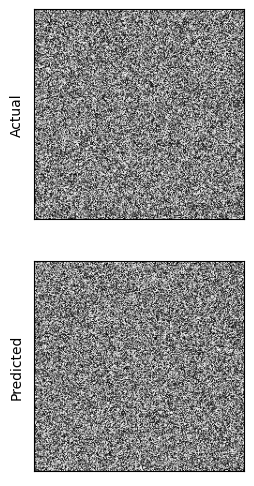

In [13]:
get_prediction_plots(y=y, yHat=yHat)

In [14]:
@torch.no_grad()
def validate_one_epoch(model: nn.Module, loader: DataLoader, criterion: nn.Module) -> float:
    model.eval()
    running_loss = 0.0
    dataset_size = 0
    
    ssim_loss = piqa.SSIM(n_channels=1)
    psnr_loss = piqa.PSNR()
    epoch_loss = 0.0
    
    pbar = tqdm(enumerate(loader), total=len(loader), desc='Evaluation')
    for step, (X, y) in pbar:
        bs = X.shape[0]
        yHat = model.forward(X)
        
        loss = criterion(yHat, y)
        
        running_loss += (bs * loss.item())
        dataset_size += bs
        epoch_loss = running_loss / dataset_size
        
        get_prediction_plots(y=y, yHat=yHat)
        
        wandb.log({
            'running valid loss': epoch_loss,
            'predictions': wandb.Image('./preds.png'),
            'validation ssim': ssim_loss(yHat, y),
            'validation psnr': psnr_loss(yHat, y)
        })
    
    return epoch_loss

# Schedulers

In [15]:
def get_optimizer(optimizer: optim):
    if config.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(
            optimizer=optimizer, 
            T_max=config.T_max, 
            eta_min=config.min_lr
        )
    elif config.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer=optimizer, 
            T_0=config.T_0, 
            eta_min=config.eta_min
        )
    elif config.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer, 
            mode='min',
            factor=0.1, 
            patience=10, 
            threshold=0.0001, 
            min_lr=config.min_lr
        )
    elif config.scheduler == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(
            optimizer=optimizer, 
            gamma=0.85
        )
    elif config.scheduler == None:
        scheduler = None
    else:
        raise NotImplementedError("The Scheduler you have asked has not been implemented")
    return scheduler

# Run Training

In [16]:
def run_training(trainloader, validloader):
    wandb.init(
        project='nasscom-taim',
        config={k:v for k, v in vars(config).items() if '__' not in k},
        name=f'iteration-{config.train_num}',
        group=config.comment
    )
    
    model = Pix2PixRNN(
        in_channels=config.in_channels, 
        latent_size=config.latent_size,
        hidden_size=config.hidden_size, 
        num_layers=config.num_layers
    ).to(config.device)
    
    criterion = nn.MSELoss()
    
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    scheduler = get_optimizer(optimizer=optimizer)
    
    history = {
        'lr': [],
        'train loss': [],
        'valid loss': []
    }
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch = -1
    best_loss = np.infty
    
    wandb.watch(models=[model], log_freq=100)
    
    for epoch in range(config.epochs):
        train_loss = train_one_epoch(model=model, optimizer=optimizer, criterion=criterion, 
                                     scheduler=scheduler, loader=trainloader)
        valid_loss = validate_one_epoch(model=model, loader=validloader, criterion=criterion)
        
#         with torch.no_grad():
#             X, y = next(iter(validloader))
#             yHat = model.forward(X)
#             yHat = yHat.permute()
        
        wandb.log({
            'lr': optimizer.param_groups[0]['lr'], 
            'epoch train loss': train_loss, 
            'epoch valid loss': valid_loss
        })
        
        history['lr'].append(optimizer.param_groups[0]['lr'])
        history['train loss'].append(train_loss)
        history['valid loss'].append(valid_loss)
        
        print(f'Validation Loss: {valid_loss:.5f}')
        
        if valid_loss < best_loss:
            print(f'{c_}Validation decreased from {best_loss:.5f} to {valid_loss:.5f}')
            best_loss = valid_loss
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            
            path = f'../../best-models/MODEL-{config.train_num}.bin'
            torch.save(best_model_wts, path)
            wandb.save(path)
            
            print(f"Model Saved{sr_}")
        
    model.load_state_dict(torch.load(f'../best-models/MODEL-{config.trial_num}.bin'))
    return model, history

# Dataset

In [17]:
import os
dirs = os.listdir('../../data/dataset/')
dirs = dirs[:-1]

In [18]:
paths_df = {}

for dir_ in dirs:
    paths = os.listdir(f'../../data/dataset/{dir_}')
    paths_df[dir_] = [f'../../data/dataset/{dir_}/{path}' for path in sorted(paths)]

    
import pandas as pd
paths_df = pd.DataFrame(paths_df)

In [19]:
paths_df

,images
0,../../data/dataset/images/2017-01.png
1,../../data/dataset/images/2017-02.png
2,../../data/dataset/images/2017-03.png
3,../../data/dataset/images/2017-04.png
4,../../data/dataset/images/2017-05.png
5,../../data/dataset/images/2017-06.png
6,../../data/dataset/images/2017-07.png
7,../../data/dataset/images/2017-08.png
8,../../data/dataset/images/2017-09.png
9,../../data/dataset/images/2017-10.png


In [20]:
paths_df.to_csv('../../aqi-images.csv', index=False)

In [21]:
input_paths = []
output_paths = []
window_size = 5

for ix in range(0, len(paths_df) - window_size):
    input_paths.append(paths_df.iloc[ix:ix + window_size].reset_index(drop=True))
    output_paths.append(paths_df.iloc[ix + window_size])

In [22]:
len(input_paths), len(output_paths)

(55, 55)

In [23]:
input_paths[1]

,images
0,../../data/dataset/images/2017-02.png
1,../../data/dataset/images/2017-03.png
2,../../data/dataset/images/2017-04.png
3,../../data/dataset/images/2017-05.png
4,../../data/dataset/images/2017-06.png


In [24]:
output_paths[0]

images    ../../data/dataset/images/2017-06.png
Name: 5, dtype: object

In [25]:
for x in output_paths[0]:
    print(x)

../../data/dataset/images/2017-06.png


In [26]:
transforms = A.Compose([
    A.Resize(224, 224),
    A.ToGray(),
    ToTensorV2()
])

In [27]:
X = None

for ix in range(window_size):
    paths = input_paths[0].iloc[ix]
    input_ = None
    for p in paths:
        img = plt.imread(p)[:, :, :-1]
        img = transforms(image=img)['image'].mean(axis=0).unsqueeze(0)
        if input_ is None:
            input_ = img
        else:
            input_ = torch.cat([input_, img], axis=0)
    if X is None:
        X = input_.unsqueeze(1)
    else:
        X = torch.cat([X, input_.unsqueeze(1)], axis=1)
X.shape

torch.Size([1, 5, 224, 224])

In [28]:
output_paths[0]

images    ../../data/dataset/images/2017-06.png
Name: 5, dtype: object

In [29]:
X = None

for ix in range(1):
    paths = output_paths[0]
    input_ = None
    for p in paths:
        print(p)
        img = plt.imread(p)[:, :, :-1]
        img = transforms(image=img)['image'].mean(axis=0).unsqueeze(0)
        if input_ is None:
            input_ = img
        else:
            input_ = torch.cat([input_, img], axis=0)
    if X is None:
        X = input_
    else:
        X = torch.cat([X, input_], axis=1)
X.shape

../../data/dataset/images/2017-06.png


torch.Size([1, 224, 224])

In [30]:
class Pix2PixRNNDataset(Dataset):
    # TODO: Implement Datasets
    def __init__(self, df: pd.DataFrame, window_size: int) -> None:
        super(Pix2PixRNNDataset, self).__init__()
        self.input_paths = []
        self.output_paths = []
        self.window_size = window_size

        for ix in range(0, len(df) - self.window_size):
            self.input_paths.append(df.iloc[ix:ix + window_size])
            self.output_paths.append(df.iloc[ix + window_size])

        self.transforms = A.Compose([
            A.Resize(224, 224),
            A.ToGray(),
            ToTensorV2()
        ])

    def __len__(self) -> int:
        return len(self.input_paths)
    
    def __getitem__(self, ix: int) -> Dict[str, torch.Tensor]:
        x = None
        input_paths = self.input_paths[ix]
        output_paths = self.output_paths[ix]

        for ix in range(self.window_size):
            paths = input_paths.iloc[ix]
            input_ = None
            for p in paths:
                img = plt.imread(p)[:, :, :-1]
                img = self.transforms(image=img)['image'].mean(axis=0).unsqueeze(0)
                if input_ is None:
                    input_ = img
                else:
                    input_ = torch.cat([input_, img], axis=0)
            if x is None:
                x = input_.unsqueeze(1)
            else:
                x = torch.cat([x, input_.unsqueeze(1)], axis=1)

        y = None
        for ix in range(1):
            paths = output_paths
            input_ = None
            for p in paths:
                img = plt.imread(p)[:, :, :-1]
                img = self.transforms(image=img)['image'].mean(axis=0).unsqueeze(0)
                if input_ is None:
                    input_ = img
                else:
                    input_ = torch.cat([input_, img], axis=0)
            if y is None:
                y = input_
            else:
                y = torch.cat([x, input_], axis=1)
        
        return x, nn.Sigmoid()(y)

In [31]:
dataset = Pix2PixRNNDataset(df=pd.read_csv('../../aqi-images.csv'), window_size=5)
print(dataset)

In [32]:
dataloader = DataLoader(dataset=dataset, batch_size=2)
print(dataloader)

In [33]:
X, y = next(iter(dataloader))
y.shape

torch.Size([2, 1, 224, 224])

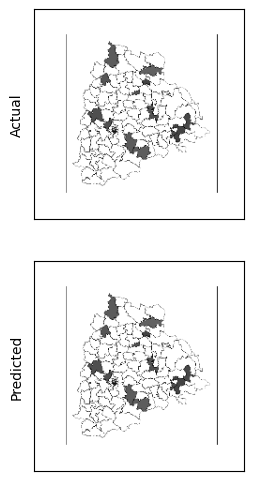

In [34]:
get_prediction_plots(y=y, yHat=y)


# Training

In [35]:
df = pd.read_csv('../../aqi-images.csv')
df

,images
0,../../data/dataset/images/2017-01.png
1,../../data/dataset/images/2017-02.png
2,../../data/dataset/images/2017-03.png
3,../../data/dataset/images/2017-04.png
4,../../data/dataset/images/2017-05.png
5,../../data/dataset/images/2017-06.png
6,../../data/dataset/images/2017-07.png
7,../../data/dataset/images/2017-08.png
8,../../data/dataset/images/2017-09.png
9,../../data/dataset/images/2017-10.png


In [36]:
train_df = df.iloc[:500]
valid_df = df.iloc[500:]

In [37]:
train_dataset = Pix2PixRNNDataset(df=train_df, window_size=6)
valid_dataset = Pix2PixRNNDataset(df=valid_df, window_size=6)

train_loader = DataLoader(dataset=train_dataset, batch_size=config.train_bs)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=config.valid_bs)

In [ ]:
run_training(trainloader=train_loader, validloader=valid_loader)

wandb: Currently logged in as: aaparajit02. Use `wandb login --relogin` to force relogin
